In [1]:
import os
import numpy as np
from herbie import Herbie
import xarray as xr
import h5py
from multiprocessing import Pool

/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:60: UserWarning: Curl is not in system Path. Herbie won't be able to download GRIB files.
  warnings.warn(


In [2]:
IMERG_data_dir = "/network/group/aopp/predict/TIP021_MCRAECOOPER_IFS/IMERG_V07/"
IMERG_file_name = f"{IMERG_data_dir}/2018/Jan/3B-HHR.MS.MRG.3IMERG.20180101-S000000-E002959.0000.V07B.HDF5"
        
# HDF5 in the ICPAC region
h5_file = h5py.File(IMERG_file_name)
latitude = h5_file['Grid']["lat"][763:1147]
longitude = h5_file['Grid']["lon"][1991:2343]
h5_file.close()

level = {'pres':'sfc',
         'hgt':'sfc',
        'tmp':'2m',
        'ugrd':'hgt',
        'vgrd':'hgt',
        'pwat':'eatm',
        'cape':'sfc',
        'msl':'msl',
        'apcp':'sfc'}


def get_gefs_herbie(variable):

    dates=np.arange('2017-01-01','2025-01-01',dtype='datetime64[D]')
    
    for date in dates:

        year = str(date).split('-')[0]

        ds_all = []

        if date.astype(object).year>2019:
            members = ['c00','p01','p02','p03','p04']
        else:
            members = np.arange(5)
            
        for member in members:

            if date.astype(object).year>2019:
                ds = []
                for fxx in np.arange(6,175,6):
                    ds_temp = Herbie(date, fxx=int(fxx), model="gefs", member=member, product="atmos.5",
                                save_dir="/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/").xarray(variable.upper())
                    if variable=='cape':
                        ds_temp = ds_temp[1]
                    if variable=='msl' and date.astype(object).year==2021:
                        ds_temp = ds_temp.prmsl.to_dataset()
                    ds_temp = ds_temp.rename({'number':'member'})
                    ds.append(ds_temp.expand_dims({'step':[ds_temp.step.values]}))
                ds = xr.concat(ds,dim='step')
            else:
                    
                if variable=='msl':
                    ds = Herbie(date,
                      model="gefs_reforecast",  member=member, variable_level=f"pres_{level[variable]}",
                                save_dir="/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/").xarray(remove_grib=True) 
                else:
                    ds = Herbie(date,
                      model="gefs_reforecast",  member=member, variable_level=f"{variable}_{level[variable]}",
                               save_dir="/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/").xarray(remove_grib=True)

                if variable in ['ugrd','vgrd']:
                    ds = ds[0]
                elif isinstance(ds,list) and variable=='apcp':
                    ds = ds[1]
            

            vars_to_drop = [v for v in ds.coords if v not in ['latitude','longitude','step','valid_time']]
            ds = ds.drop_attrs().drop_vars(vars_to_drop)
            #ds['longitude']=ds['longitude'].values-180

            lon_start = longitude[0]-0.5
            lon_end = longitude[-1]+0.5
            lat_start = latitude[0]-0.5
            lat_end = latitude[-1]+0.5

            ds_all.append(ds.sel({'longitude':longitude,'latitude':latitude},
                                  method='nearest').drop_duplicates('latitude').drop_duplicates('longitude').sel({'step':[np.timedelta64(t,'h')\
                                                                 for t in np.arange(6,175,6)]}).expand_dims({'member':[member]}))##used to be 30,175
           
        out_path = f'/network/group/aopp/predict/AWH026_NATH_GFSAIMOD/netcdf/gefs_apcp_only/{year}/'
        if not os.path.exists(out_path):
            os.makedirs(out_path)
            
        file_name = f'{variable}_{year}.zarr'
        if os.path.exists(out_path+file_name):
            xr.concat(ds_all,dim='member').expand_dims({'time':[date.astype('datetime64[ns]')]}).to_zarr(out_path+file_name,mode='a-',append_dim='time')
        else:
            xr.concat(ds_all,dim='member').expand_dims({'time':[date.astype('datetime64[ns]')]}).to_zarr(out_path+file_name,mode='w')

n_workers=8
variables = ['pres','tmp','ugrd','vgrd','pwat','cape','msl','apcp']

for var in variables:

    get_gefs_herbie(var)

    
            

✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181102]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181103]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181104]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181105]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181106]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181107]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181108]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181109]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181110]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181111]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181112]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181113]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181114]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181115]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181116]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181117]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181118]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181119]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181120]
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181121]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181122]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181123]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181124]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181125]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181126]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181127]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181128]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181129]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181130]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181201]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181202]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181203]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181204]
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181210]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181211]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181212]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181213]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181214]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181215]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181216]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181217]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181218]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181219]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181220]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181221]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181222]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181223]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181224]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181225]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181226]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181227]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181228]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181229]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181230]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20181231]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2018-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190101]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190102]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190103]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190104]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190105]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190106]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190107]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190108]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190109]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190110]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190111]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190112]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190113]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190114]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190115]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190116]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190117]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190118]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190119]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190120]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190121]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190122]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190123]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190124]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190125]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190126]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190127]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190128]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190129]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190130]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190131]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jan-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190201]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190202]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190203]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190204]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190205]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190206]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190207]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190208]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190209]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190210]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190211]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190212]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190213]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190214]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190215]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190216]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190217]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190218]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190219]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190220]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190221]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190222]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190223]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190224]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190225]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190226]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190227]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190228]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Feb-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190301]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190302]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190303]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190304]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190305]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190306]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190307]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190308]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190309]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190310]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190311]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190312]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190313]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190314]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190315]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190316]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190317]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190318]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190319]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190320]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190321]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190322]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190323]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190324]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190325]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190326]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190327]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190328]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190329]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190330]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190331]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Mar-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190401]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190402]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190403]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190404]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190405]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190406]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190407]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190408]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190409]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190410]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190411]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190412]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190413]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190414]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190415]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190416]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190417]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190418]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190419]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190420]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190421]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190422]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190423]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190424]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190425]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190426]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190427]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190428]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190429]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190430]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Apr-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190501]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190502]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190503]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190504]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190505]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190506]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190507]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190508]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190509]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190510]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190511]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190512]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190513]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190514]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190515]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190516]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190517]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190518]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190519]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190520]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190521]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190522]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190523]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190524]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190525]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190526]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190527]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190528]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190529]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190530]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190531]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-May-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190601]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190602]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190603]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190604]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190605]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190606]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190607]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190608]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190609]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190610]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190611]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190612]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190613]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190614]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190615]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190616]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190617]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190618]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190619]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190620]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190621]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190622]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190623]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190624]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190625]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190626]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190627]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190628]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190629]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190630]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jun-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190701]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190702]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190703]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190704]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190705]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190706]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190707]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190708]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190709]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190710]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190711]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190712]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190713]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190714]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190715]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190716]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190717]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190718]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190719]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190720]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190721]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190722]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190723]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190724]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190725]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190726]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190727]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190728]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190729]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190730]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190731]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Jul-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190801]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190802]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190803]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190804]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190805]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190806]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190807]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190808]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190809]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190810]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190811]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190812]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190813]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190814]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190815]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190816]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190817]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190818]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190819]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190820]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190821]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190822]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190823]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190824]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190825]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190826]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190827]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190828]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190829]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190830]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190831]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Aug-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190901]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190902]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190903]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190904]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190905]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190906]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190907]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190908]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190909]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190910]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190911]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190912]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190913]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190914]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190915]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190916]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190917]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190918]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190919]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190920]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190921]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190922]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190923]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190924]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190925]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190926]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190927]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190928]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190929]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20190930]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Sep-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191001]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191002]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191003]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191004]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191005]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191006]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191007]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191008]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191009]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191010]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191011]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191012]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191013]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191014]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191015]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191016]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191017]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191018]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191019]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191020]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191021]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191022]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191023]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191024]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191025]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191026]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191027]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191028]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191029]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191030]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191031]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Oct-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191101]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191102]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191103]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191104]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191105]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191106]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191107]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191108]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191109]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191110]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191111]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191112]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191113]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191114]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191115]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191116]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191117]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191118]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191119]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191120]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191121]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191122]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191123]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191124]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191125]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191126]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191127]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191128]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191129]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191130]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Nov-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191201]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191202]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191203]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-03 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191204]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-04 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191205]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191206]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-06 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191207]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-07 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191208]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191209]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191210]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191211]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-11 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191212]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-12 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191213]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-13 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191214]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-14 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191215]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191216]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191217]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-17 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191218]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-18 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191219]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-19 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191220]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-20 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191221]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-21 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191222]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-22 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191223]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191224]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-24 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191225]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-25 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191226]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-26 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191227]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-27 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191228]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191229]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-29 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191230]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-30 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs_reforecast/20191231]


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs_reforecast ┊ product=GEFSv12/reforecast ┊ 2019-Dec-31 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/n/nath/nobackups/miniforge3/envs/coiled/lib/python3.11/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2020-Jan-01 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs/20200101]


sh: 1: curl: not found


EOFError: No valid message found: PosixPath('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs/20200101/subset_75b2000a__gec00.t00z.pgrb2af06')

In [4]:
IMERG_data_dir = "./"
IMERG_file_name = f"{IMERG_data_dir}/3B-HHR.MS.MRG.3IMERG.20180101-S000000-E002959.0000.V07B.HDF5"
        
# HDF5 in the ICPAC region
h5_file = h5py.File(IMERG_file_name)
latitude = h5_file['Grid']["lat"][763:1147]
longitude = h5_file['Grid']["lon"][1991:2343]

In [29]:
ds = Herbie('2022-06-20', fxx=6, model="gefs", member=1, product="atmos.25",
                            save_dir="/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/").xarray('APCP')

✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2022-Jun-20 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/grib/gefs/20220620]


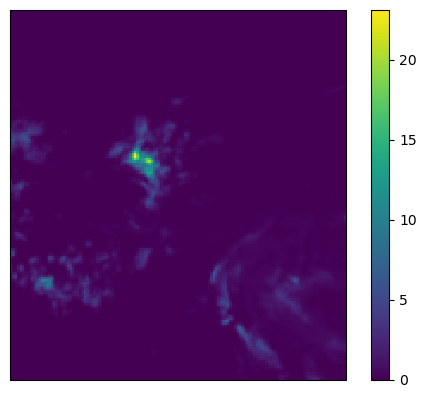

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection = ccrs.PlateCarree())

ds = ds.sel({'longitude':longitude,'latitude':latitude},
            method='nearest').drop_duplicates('latitude').drop_duplicates('longitude')#
mesh = ax.pcolormesh(ds.longitude.values,ds.latitude.values,np.squeeze(ds.tp.values))
plt.colorbar(mesh)